# Trace Data Consulting Project: Topic Modeling - LDA

### By: Amanda Ma & Pengyuan Chen
#### Data Consulting Committee, Fall 2019
#### Student Association for Applied Statistics
---





**Topic Modeling** is a form of statistical/probabilistic modeling used for discovering abstract "topics" from collections of text documents. As more textual information becomes available, topic modeling provides us a way to understand and cluster documents. A document refers to a single body of textual content assumed to cover one or a few topics. 

**Latent Dirichlet Allocation** (LDA) is an example of topic modeling used for analyzing various collections of discrete textual data. In particular, the LDA model aims to uncover underlying distributions of topics per document and words per topic.

* Latent: refers to *hidden* topic structures
* Dirichlet: refers to the *statistical distribution* that determines per-document topic distribution and per-topic word distribution
* Allocation: refers to *word allocation per topic*

![Topic Modeling Diagram](https://2.bp.blogspot.com/-UO8E6wws1Go/XGWgbLTPJnI/AAAAAAAABoQ/tGuBrjfJZ1UGmUQ112ZCv3gAu3Tg0O1FACLcBGAs/s1600/image001-min.png)

---

Given 10,000 JSON files consisting of various company data, we aim to infer data content (*topics*) using the LDA model.
Each JSON file is treated as a single document, with file sizes ranging from 105 bytes to 198 KB. 

Below is a data sample from a randomly chosen JSON file: 
  
```
{"user":{
  "user_id": "567sad7867asd",
  "${EMAIL_ADDRESS.KEY}": "${EMAIL_ADDRESS.VALUE}",
  "phone": "${PHONE.VALUE}",
  "review_count": 56,
  "friends": [
    "wqoXYLWmpkEH0YvTmHBsJQ",
    "KUXLLiJGrjtSsapmxmpvTA",
    "6e9rJKQC3n0RSKyHLViL-Q"
  ],
  ...
```
There are several characteristics about the data:
  - Every JSON file contains a string representation of a dictionary 
  - Within the dictionary, there are three types of relationships: 
    - key:dict --> dict holds properties of key
    - key:list --> list holds elements, each an example of key
    - key:value --> value is a single example of key

We will extract and encode the keys from the JSON files, including keys in nested dictionaries, before feeding them into the model.




# Data Loading and Cleaning

In [0]:
# Helper Function for Data Cleaning Dependencies
import re
import os
import string

In [0]:
# Progress bar
from tqdm import tqdm

In [0]:
# Helper Functions for Data Cleaning

def getkeys(file_path): 
  """
  Code by Luke

  Parameter(s)
  ------------
  file_path : str
    file path to the JSON file containing string representation of dictionary

  Returns
  -------
  list
    contains keys (including any nested key(s)) in the dictionary
  """
  assert isinstance(file_path, str), 'file_path must be a string'

  file_read = open(file_path, "rb").read()
  file_read = file_read.decode("utf-8").encode("ascii", "ignore").decode('ascii')
  text = re.sub(r'\"\"', "\"", file_read)
  text = re.findall(r'\"[^\"]+\":', file_read)
  return [re.sub(r'[\":]', '', t) for t in text]

def parse(word_string): 
  """
  Code by Yehchan, Amal, Luke, & Amanda

  Parameter(s)
  ------------
  word_string : str
    string containing words to be parsed 

  Returns
  -------
  list
    contains lowercase parsed words from word_string

  >>> parse('user')
  ['user']
  >>> parse('userid')
  ['userid']
  >>> parse("IPAddress")
  ['ip', 'address']
  >>> parse("user_id")
  ['use', 'id']
  >>> parse("credit.card")
  ['credit', 'card']
  >>> parse("${EMAIL_ADDRESS.KEY}")
  ['email', 'address', 'key']
  """
  assert isinstance(word_string, str), 'word_string must be a string'
  
  space = " "
  word_string = re.sub(r'[^a-zA-Z]+', space, word_string)
  word_string = re.sub(r"\b([A-Z]*)([A-Z][a-z])", r'\1 \2', word_string)
  word_string = re.sub(r"([a-z])([A-Z])", r'\1 \2', word_string)
  word_list = word_string.lower().split(space)
  return list(filter(lambda s: s, word_list))

def get_doc(folder_path): 
  """
  Code by Pengyuan & Amanda 
  Parameter(s)
  ------------
  folder_path : str
    folder path to the JSON file containing string representation of dictionary

  Returns
  -------
  list
    contains pre-processed (parsed, lowercase) keys from the dictionary
  """
  assert isinstance(folder_path, str), 'folder_path must be a string'

  prepros_keys = []
  for f in tqdm(os.listdir(folder_path)): 
    full_path = os.path.join(folder_path, f) 
    key_list = getkeys(full_path) 
    parsed = []
    for k in key_list: 
      parsed.extend(parse(k)) 
    prepros_keys.append(parsed)
  return prepros_keys

In [0]:
file_path = '/content/'

In [0]:
# json_filesnames is a list of 10000 JSON file names for reference
json_filenames = os.listdir(file_path)
assert isinstance(json_filenames, list)
assert isinstance(json_filenames[0], str)

# Showing five JSON file names
json_filenames[:5]

['1QnjfBZAZRX0d4I8gdiiEqMTPOy.json',
 '1Qnjfdz7w5bjtOJkaMnv1OoCXjh.json',
 '1QnjfJwZZVjheoSMAacfy2YTiRh.json',
 '1QnjecWAw6QYZZPULDdMriL3DiI.json',
 '1QnjecgYoRqEJcHJCnmnRbCyb9D.json']

In [0]:
# documents is a list of lists of keys
documents = get_doc(file_path)
assert isinstance(documents, list)
assert isinstance(documents[0], list)

# Showing first ten words of first document
documents[0][:10]

100%|██████████| 10000/10000 [00:27<00:00, 368.08it/s]


['inventory',
 'items',
 'inventory',
 'items',
 'id',
 'sku',
 'created',
 'at',
 'updated',
 'at']

In [0]:
# For flattening list of lists
import itertools

In [0]:
# words is a list of all keys
words = list(itertools.chain(*documents))
#corpus is a single string 
corpus = ' '.join(words)

In [0]:
# Data Cleaning Dependencies
!pip install stop_words

from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer 

en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=591e51a578231a0bac18862198331c36c5ab40cc5240d2aedcada60663441ca5
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
# cleaned_texts is a list of lists of strings of cleaned words (each list = doc)
cleaned_texts = []

for text in tqdm(documents): 
  stemmed = [p_stemmer.stem(word) for word in text if not word in en_stop]
  cleaned_texts.append(stemmed)

100%|██████████| 10000/10000 [01:35<00:00, 104.73it/s]


In [0]:
# cleaned_words is a list of all cleaned words
cleaned_words = list(itertools.chain(*cleaned_texts))
# cleaned_corpus is a single string of cleaned words
cleaned_corpus = ' '.join(cleaned_words)

# Exploratory Analysis

In [0]:
# EDA/Visualization Dependencies
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
def create_words_freq(list_of_words): 
  """
  Code by Amanda

  Parameter(s)
  ------------
  list_of_words : list
    a list of strings (single words)

  Returns
  -------
  dict
    key:value --> word:frequency
  """
  assert isinstance(list_of_words, list), 'list_of_words must be a list'

  words_pd = pd.Series(list_of_words)
  counts = words_pd.value_counts()
  words = counts.index
  words_and_frequencies = dict()
  for word in words: 
    words_and_frequencies[word] = counts[word]
  return words_and_frequencies

In [0]:
# Dictionaries --> word:freq
uncleaned_word_freq = create_words_freq(words)
cleaned_word_freq = create_words_freq(cleaned_words)

In [0]:
# Generating word cloud for entire corpus
wordcloud = WordCloud(max_words = len(cleaned_words), 
                      background_color = 'white', 
                      stopwords = set(),
                      colormap = 'inferno',
                      random_state = 42)
wc_entire_corpus = wordcloud.generate_from_frequencies(cleaned_word_freq)

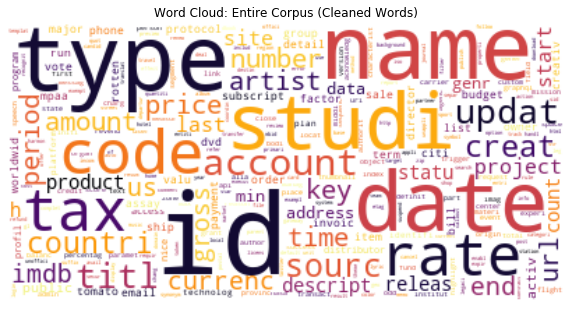

In [0]:
# Plotting Word cloud for entire corpus
plt.figure(figsize = (10, 10))
# Interpolation --> smooth image
plt.imshow(wc_entire_corpus, interpolation = 'bilinear') 
plt.title('Word Cloud: Entire Corpus (Cleaned Words)')
plt.axis('off')
plt.show()

# Modeling

In [0]:
# Modeling Dependencies
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel 
from gensim.models import CoherenceModel

# Coherence Visualization Dependencies
import plotly.graph_objects as go
import numpy as np

In [0]:
# Creating dictionary and corpus model inputs
common_dictionary = Dictionary(cleaned_texts)
common_dictionary.filter_extremes(no_below = 100, 
                                  no_above = 0.5)
corpus_input = [common_dictionary.doc2bow(text) for text in cleaned_texts]

In [0]:
# Storing models & coherence scores for up to 20 topics
number_topics = list(range(1, 21))
models = []
coherences = []

for num in range(1, 21): 
  model = LdaModel(corpus_input, 
                   num_topics = num, 
                   id2word = common_dictionary,
                   random_state=42)
  models.append(model)
  cm = CoherenceModel(model = model, 
                      texts = cleaned_texts,
                      corpus = corpus_input,
                      coherence = 'u_mass')
  coherences.append(cm.get_coherence())

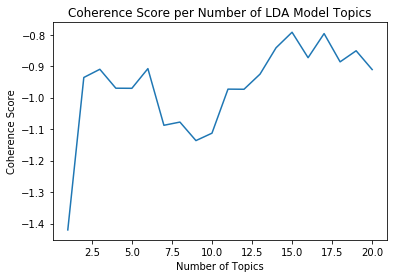

In [33]:
# Plotting coherence score vs number of topics
plt.plot(number_topics, coherences)
plt.title('Coherence Score per Number of LDA Model Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [0]:
# topic_nums contains chosen topic numbers
topic_nums = [4, 6, 8, 12, 13, 17, 18] 
select_models = [models[n-1] for n in topic_nums]

In [0]:
# Showing model topic distribution with 4 topics
select_models[0].print_topics()

[(0,
  '0.054*"rate" + 0.029*"imdb" + 0.029*"us" + 0.029*"gross" + 0.028*"site" + 0.028*"titl" + 0.026*"key" + 0.024*"h" + 0.020*"min" + 0.020*"product"'),
 (1,
  '0.172*"studi" + 0.041*"sourc" + 0.041*"project" + 0.032*"titl" + 0.030*"factor" + 0.030*"assay" + 0.030*"protocol" + 0.030*"public" + 0.021*"data" + 0.020*"valu"'),
 (2,
  '0.195*"tax" + 0.047*"ship" + 0.038*"percentag" + 0.037*"zone" + 0.018*"genr" + 0.016*"album" + 0.016*"music" + 0.012*"provinc" + 0.010*"rate" + 0.008*"sourc"'),
 (3,
  '0.027*"artist" + 0.025*"period" + 0.017*"price" + 0.014*"payment" + 0.012*"profil" + 0.010*"bill" + 0.010*"start" + 0.009*"close" + 0.008*"activ" + 0.008*"key"')]

# Analysis of Results + More Visualizations

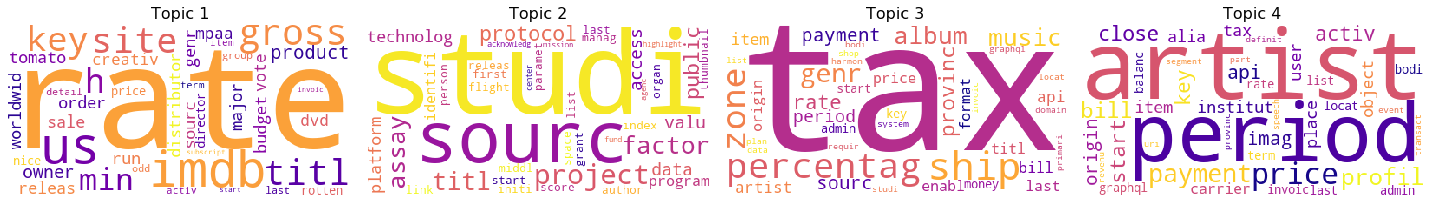

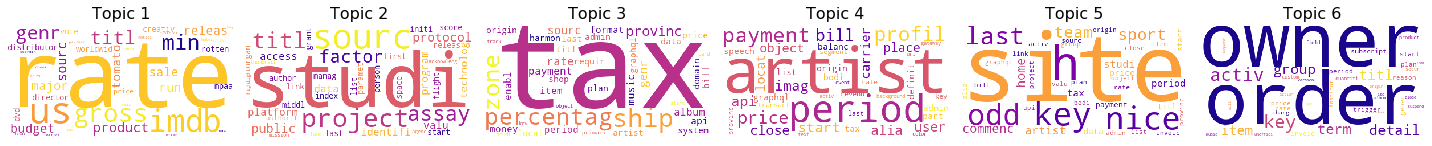

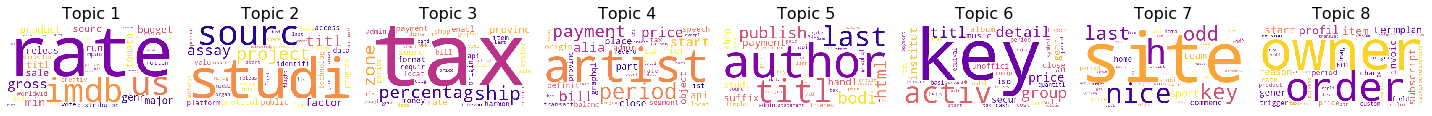

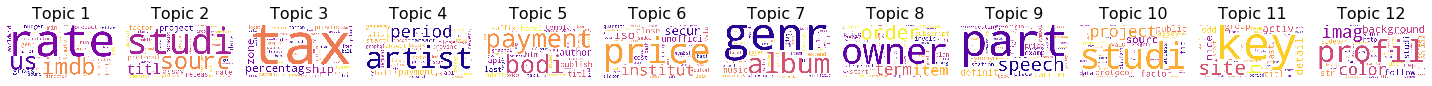

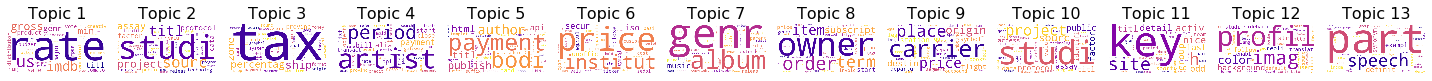

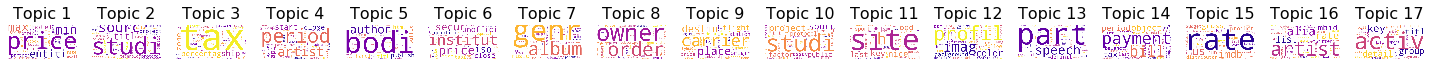

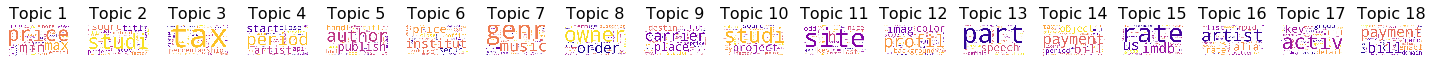

In [0]:
# Wordcloud Visualization of Topics

for idx, model in enumerate(select_models): 
  wc = WordCloud(max_words = len(corpus_input),
                 background_color = 'white',
                 stopwords = set(), 
                 colormap = 'plasma')
  topics = model.show_topics(formatted=False, num_topics = topic_nums[idx], num_words = 40)

  fig, axes = plt.subplots(1, topic_nums[idx], figsize=(20,20), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      wc.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(wc)
      plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
      plt.gca().axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()